# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

In [120]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import layers

from utils import get_activation_function, max_pooling

## 1. Utility Functions

In [121]:
def plot_data(X: np.ndarray, y: np.ndarray) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        ax.set_xlabel(true_label)

    plt.tight_layout()
    plt.show()

## 2. Load Data

In [122]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

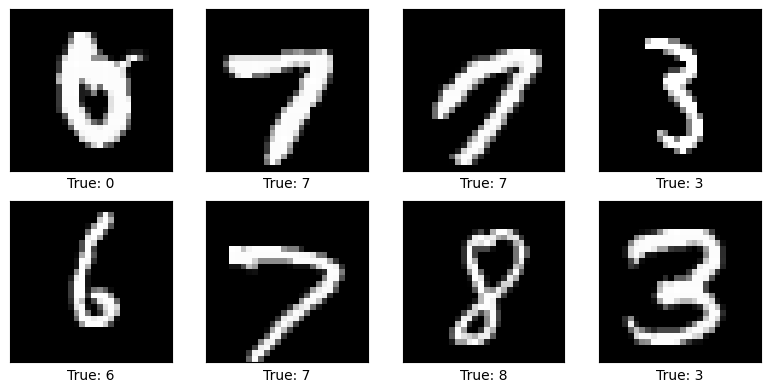

In [123]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

In [124]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [125]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [126]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [127]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Model: Multi-Layer Perceptron

### 4.2 With Keras

In [128]:
inp_shape = X_train.shape[1:]

In [129]:
model = keras.models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [131]:
batch_size = 128
epochs = 15

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.4330 - accuracy: 0.8734 - val_loss: 0.1113 - val_accuracy: 0.9675
Epoch 2/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 0.9710 - val_loss: 0.0810 - val_accuracy: 0.9750
Epoch 3/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0554 - accuracy: 0.9830 - val_loss: 0.0936 - val_accuracy: 0.9722
Epoch 4/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0370 - accuracy: 0.9891 - val_loss: 0.0687 - val_accuracy: 0.9785
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0654 - val_accuracy: 0.9813
Epoch 6/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0806 - val_accuracy: 0.9780
Epoch 7/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0887 - val_accuracy: 0.9798
Epoch 

#### 4.2.1. Model results

In [135]:
history_dict = history.history

In [136]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [137]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

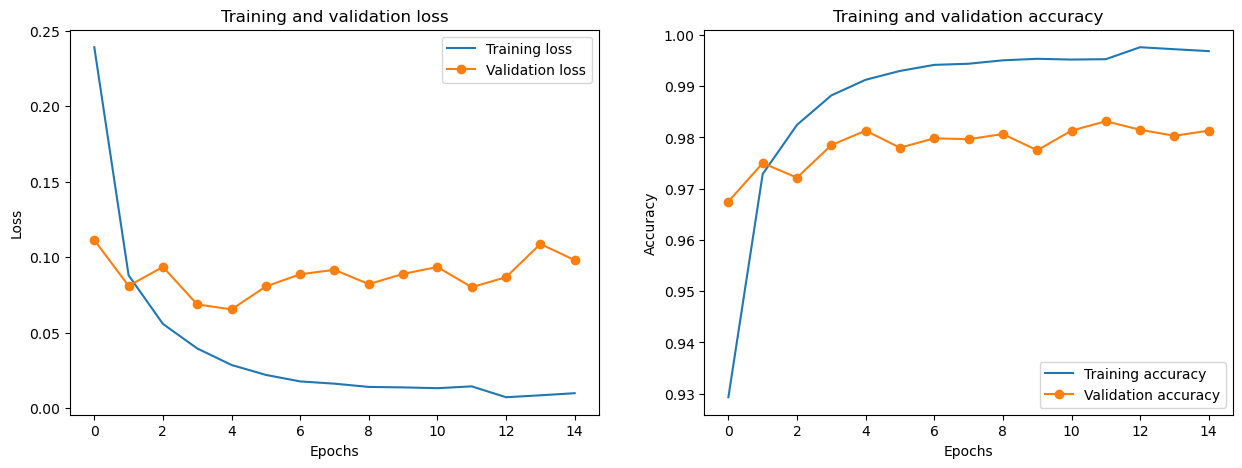

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [132]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09527543187141418
Test accuracy: 0.9804999828338623


In [133]:
y_pred = model.predict(X_test)

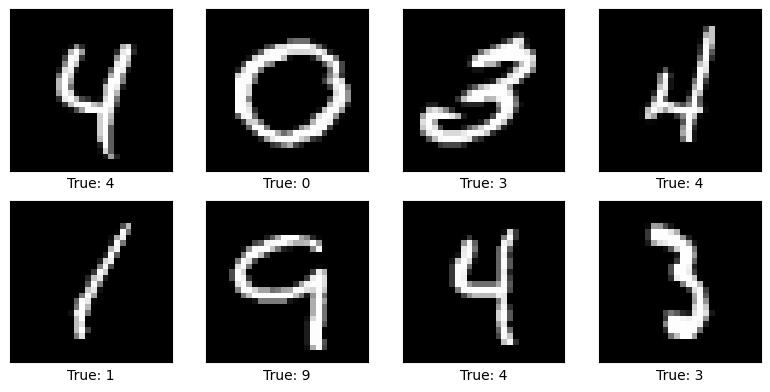

In [134]:
plot_data(X_test, np.argmax(y_pred, axis=1))